In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Inputs

In [2]:
# import observed flow
qobs= pd.read_csv('../../model/seperate_cal/combined_model/Qobs.txt',sep='\t',index_col=0)
gauge_id= 58363

### Analysis

In [3]:
# set index as datetime
qobs.index = pd.to_datetime(qobs.index)
# set headers as int
qobs.columns = qobs.columns.astype(int)

In [4]:
# Create the new DataFrame with the index and the specified column
gauge = pd.DataFrame({
    'Flow': qobs[gauge_id]  # Column specified by gauge_id
})

In [5]:
# Convert 'Value' column to numeric, forcing errors to NaN
gauge['Flow'] = pd.to_numeric(gauge['Flow'], errors='coerce')

In [6]:
# Count occurrences of -9999 per year
def count_missing_dates(df):
    # Create a water year period
    df['WaterYear'] = df.index.to_period('A-SEP')
    # Count occurrences of -9999 per year
    count_per_year = (df == -9999).groupby(df['WaterYear']).sum()
    # Drop the WaterYear column
    return count_per_year.drop(columns='WaterYear', errors='ignore')

In [7]:
# Count -9999 values
missing_count = count_missing_dates(gauge)

In [8]:
missing_count

,Flow
WaterYear,
1980,60
1981,115
1982,120
1983,120
1984,121
1985,120
1986,116
1987,120
1988,121


In [9]:
# Drop rows where any column has a value of -9999
gauge_filtered = gauge[(gauge != -9999).all(axis=1)].copy()

In [10]:
# Define a function to calculate annual sum for water years
def water_year_sum(df):
    
    # Create a water year period
    df['WaterYear'] = df.index.to_period('A-SEP')  # 'A-SEP' indicates water year ending in September

    return df.groupby('WaterYear').mean() # use either sum or mean

In [11]:
# Apply the function
annual_sum = water_year_sum(gauge_filtered)

In [12]:
# Example list of string values for each row
period_values = [
    'spin-up', 'calibration', 'calibration', 'calibration', 'calibration', 
    'validation', 'validation', 'validation', 'validation', 'validation', 
    'calibration', 'calibration', 'calibration', 'calibration', 'calibration',
    'calibration', 'calibration', 'calibration', 'calibration', 'validation', 
    'validation', 'validation', 'validation', 'validation', 'calibration', 
    'calibration', 'calibration', 'calibration', 'validation', 'validation', 
    'validation', 'validation', 'validation', 'calibration', 'calibration', 
    'calibration', 'not considered'
]
# Ensure the list length matches the number of rows in the DataFrame
annual_sum['period'] = period_values

In [13]:
# Define color mapping based on the 'period' column values
color_mapping = {
    'calibration': 'blue',  # Shade calibration periods in blue
    'validation': 'green',  # Shade validation periods in green
    'spin-up': 'grey',       # Shade other periods (e.g., spin-up) in grey
    'not considered': 'grey'
}

# Create a list of colors corresponding to each row in the 'annual_sum' DataFrame
colors = [color_mapping[period] for period in annual_sum['period']]

In [14]:
# Convert the PeriodIndex to a string format for plotting
x_labels = annual_sum.index.astype(str)

# Calculate the 25th and 75th quantiles of the 'Flow' column
quantile_25 = annual_sum['Flow'].quantile(0.25)
quantile_75 = annual_sum['Flow'].quantile(0.75)

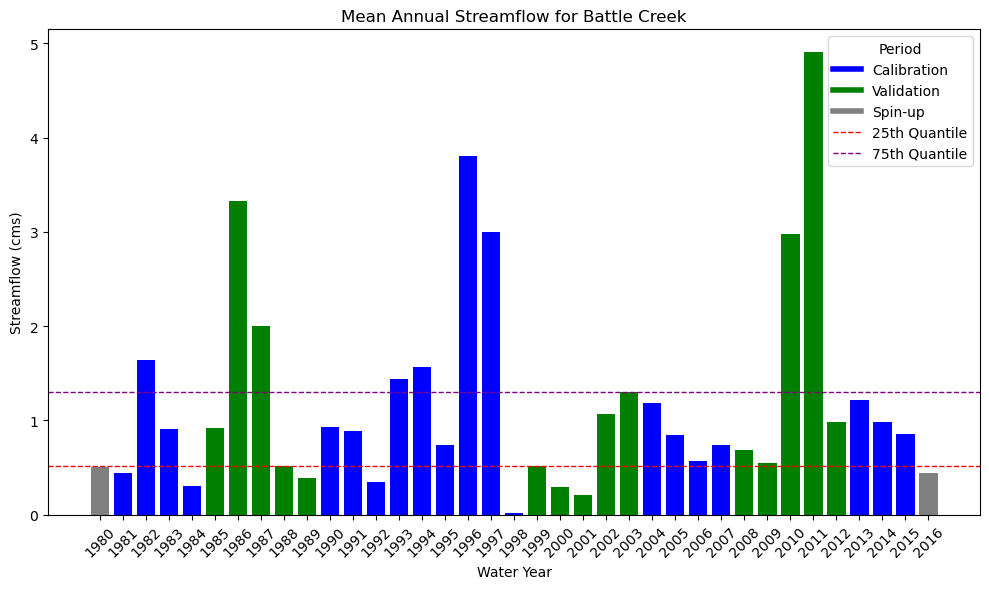

In [15]:
# Plot the annual sum with custom colors using matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(x_labels, annual_sum['Flow'], color=colors)

# Add horizontal dashed lines for the 25th and 75th quantiles
plt.axhline(y=quantile_25, color='red', linestyle='--', linewidth=1, label='25th Quantile')
plt.axhline(y=quantile_75, color='purple', linestyle='--', linewidth=1, label='75th Quantile')

plt.title('Mean Annual Streamflow for Battle Creek')
plt.xlabel('Water Year')
plt.ylabel('Streamflow (cms)')
plt.xticks(rotation=45)

# Custom legend
plt.legend(handles=[plt.Line2D([0], [0], color='blue', lw=4, label='Calibration'),
                    plt.Line2D([0], [0], color='green', lw=4, label='Validation'),
                    plt.Line2D([0], [0], color='grey', lw=4, label='Spin-up'),
                    plt.Line2D([0], [0], color='red', linestyle='--', lw=1, label='25th Quantile'),
                    plt.Line2D([0], [0], color='purple', linestyle='--', lw=1, label='75th Quantile')],
           title='Period')

plt.tight_layout()

# Save the plot as a file
plt.savefig('../../model/seperate_cal/combined_model/results/battle_annual_mean.png', dpi=300, bbox_inches='tight')  # Save with high resolution

plt.show()

In [16]:
# Separate the data into calibration and validation periods
calibration_periods = annual_sum[annual_sum['period'] == 'calibration']
validation_periods = annual_sum[annual_sum['period'] == 'validation']

# Count the number of years in each quantile range for calibration and validation periods
def count_years_in_quantile(df, q25, q75):
    below_q25 = df[df['Flow'] <= q25].shape[0]
    between_q25_q75 = df[(df['Flow'] > q25) & (df['Flow'] <= q75)].shape[0]
    above_q75 = df[df['Flow'] > q75].shape[0]
    return below_q25, between_q25_q75, above_q75

# Get counts for calibration periods
cal_below_q25, cal_between_q25_q75, cal_above_q75 = count_years_in_quantile(calibration_periods, quantile_25, quantile_75)

# Get counts for validation periods
val_below_q25, val_between_q25_q75, val_above_q75 = count_years_in_quantile(validation_periods, quantile_25, quantile_75)

# Print the results
print("Calibration Period Counts:")
print(f"Below 25th Quantile: {cal_below_q25} years")
print(f"Between 25th and 75th Quantiles: {cal_between_q25_q75} years")
print(f"Above 75th Quantile: {cal_above_q75} years")

print("\nValidation Period Counts:")
print(f"Below 25th Quantile: {val_below_q25} years")
print(f"Between 25th and 75th Quantiles: {val_between_q25_q75} years")
print(f"Above 75th Quantile: {val_above_q75} years")

Calibration Period Counts:
Below 25th Quantile: 4 years
Between 25th and 75th Quantiles: 11 years
Above 75th Quantile: 5 years

Validation Period Counts:
Below 25th Quantile: 4 years
Between 25th and 75th Quantiles: 7 years
Above 75th Quantile: 4 years


In [17]:
# Only do this if the periods have the same missing values!
cal_mean= calibration_periods['Flow'].mean()
val_mean= validation_periods['Flow'].mean()

print(f'Calibration period mean flow= {cal_mean}')
print(f'Validation period mean flow= {val_mean}')

Calibration period mean flow= 1.1212235281841774
Validation period mean flow= 1.376142065546839
